# I’m Something of a Painter Myself
**Kaggle competition**
https://www.kaggle.com/competitions/gan-getting-started

This notebook contains 1 of the 3 different DCGAN models. 
Various hyperparameters can be modified to change the outcome of the models. It is also possible to set a fixed random seed.

*The notebook is inspired by Pytorch toturial on DCGAN:* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html 


**Following outline of the notebook:**
- Importing libraries 
- Hyperparameters
- Loading the data
- Creating the generator for 64x64 pictures
- Creating the discriminator
- Weights initialization
- **DCGAN model**
- Plotting the loss function. 
- Showing a real picture and the latest created fake picture. 
- Showing the evolution of the generated pictures. 

**Extra:** Code for the generator and discriminator classes for pictures in size of 128x128 and 256x256.  

# Importing libraries

We have chosen to use the PyTorch library to build our DCGAN model 

In [1]:
import os 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as dset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
import numpy as np
import random
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## "Hyperparameters to "change" the whole model 

In [2]:
# The root to the folder where the data is stored. 
dataroot = "./Data/monet_jpg/"

# The scale of the real image size, this can be downsized. Our original picture size is 256x256
image_size = 256

# Number of pictures that should be in each batch. 
batch_size = 10

ngpu = 1

# Size of the latent vector which the fake images are generated from.
latent_size = 100

# Feature map size for the generator
feature_size_generator = 64 

# Feature map size for the generator
feature_size_discriminator = 64 

# Number of channels in the training and the final number of channels. For RGB color images this is 3.
channels = 3

# normalization rate.
learning_rate = 0.0002

# Beta value, used in the Adam optimisor. 
beta1 = 0.5


## Code notes

**https://www.kaggle.com/code/ninamaamary/dcgan-artist** : DCGAN example from Kaggle.

**path_list = os.listdir(img_dir) :** Creates a list with all the file names in the dictionary. \
**abspath = os.path.abspath(img_dir) :** creates a list with all the complete paths, so all these small files names joined with the root path. Such that each picture now has its unique path in the list. 

**transforms.Normalize() :** Normalize range of R, B and G. ([mean], [std]). Helps CNN to peform better. Have this match with the generator, such that we create pictures in the same range of colors

**ToTensor() :** Takes the image and converts it to the pytorch own picture format. 

**The transform.Compose "function" :** It changes the image to a PyTorch format, and is able to "change" the picture in certain ways. 


## Dataloader

- **Why do we need a batchsize in the Dataloader?** We pick out a number of all our pictures, so the batchsize indicates how many pictures we want to have in a batch. 
- **Why do we shuffle in the Dataloader?** We need to shuffle in order to collect "the number of batch size" pictures. Because the dataloader collects the first N numbers of pictures, we need to shuffle the order of pictures after each collection. 


In [3]:
#import dataset 
class Dataset(Dataset):
    
    def __init__(self, img_dir):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            # transforms.CenterCrop(image_size), # Crops the image, doesn't make sense to use. 
            transforms.ToTensor(),
            # transforms.Normalize([1, 0.5, 10], [1, 0.5, 10]), # Makes the picture green. 
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            # transforms.Normalize([1, 1, 1], [1, 1, 1]),
            ############################### Normalize range of R, B and G. ([mean], [std]). Helps CNN to peform better. 
        ])


    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, index):
        path = self.img_list[index]
        img = Image.open(path).convert('RGB')
        return self.transform(img)

In [4]:
monet_dataset = Dataset(dataroot)

data_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

In [5]:
print("The number of batches in the data_loader:", len(data_loader))
print("The number of pictures in a batch:", data_loader.batch_size, "\n")
print("A single example of a picture:", data_loader.dataset[0])

The number of batches in the data_loader: 30
The number of pictures in a batch: 10 

A single example of a picture: tensor([[[ 0.4118,  0.5137,  0.5843,  ...,  0.6863,  0.6078,  0.5137],
         [ 0.4588,  0.4902,  0.5373,  ...,  0.7098,  0.6314,  0.5373],
         [ 0.4588,  0.4510,  0.4667,  ...,  0.7569,  0.6863,  0.6000],
         ...,
         [ 0.2235,  0.4980,  0.5373,  ...,  0.2157,  0.1216,  0.0745],
         [ 0.2078,  0.5373,  0.5608,  ...,  0.0824,  0.1059,  0.0275],
         [ 0.1451,  0.4431,  0.5686,  ..., -0.0980, -0.0196, -0.0745]],

        [[ 0.3961,  0.4980,  0.5843,  ...,  0.6078,  0.4980,  0.4039],
         [ 0.4353,  0.4902,  0.5294,  ...,  0.6157,  0.5216,  0.4275],
         [ 0.4431,  0.4510,  0.4588,  ...,  0.6627,  0.5765,  0.4902],
         ...,
         [ 0.0980,  0.3882,  0.4431,  ..., -0.3020, -0.4353, -0.4980],
         [ 0.0745,  0.4118,  0.4588,  ..., -0.2549, -0.2471, -0.3490],
         [ 0.0039,  0.3176,  0.4431,  ..., -0.3255, -0.2863, -0.3412]],



## Plotting an image from the training data.

Code is directly taken from: 
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

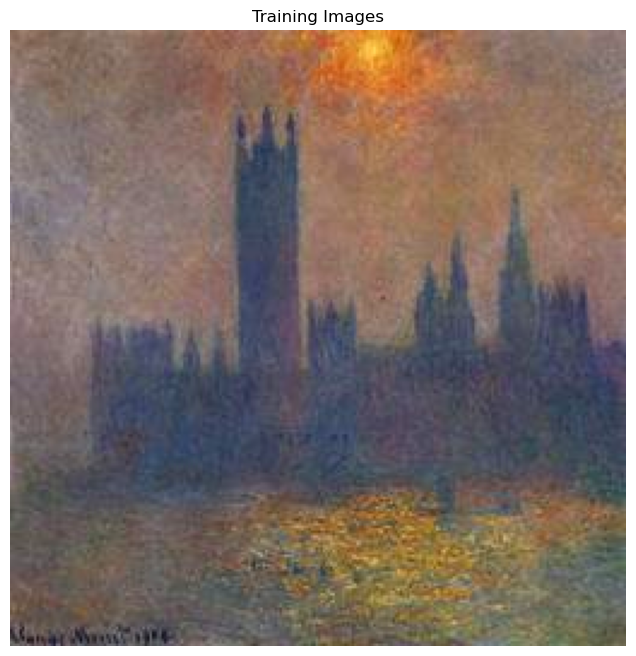

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

#### ConvTranspose2d( in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None

- in_channels (number of channels in the input image), 
- out_channels (number of channels produced by the convolution), 
- kernel_size (size of the convolving kernel), 
- stride=1 (stride of the convolution. Default: 1), 
- padding=0 ---(dilation * (kernel_size - 1) - padding --- zero-padding will be added to both sides of each dimension in the input. Default: 0), 
- output_padding=0 (Additional size added to one side of each dimension in the output shape. Default: 0), 
- groups=1 (Number of blocked connections from input channels to output channels. Default: 1), 
- bias=True (If True, adds a learnable bias to the output.), 
- dilation=1 (Spacing between kernel elements. Default: 1), 
- padding_mode='zeros', 
- device=None, 
- dtype=None)

In [7]:
#generator class
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( in_channels=latent_size, out_channels=feature_size_generator * 32, kernel_size=4, stride=1, padding=0, bias=False), 
            nn.BatchNorm2d(feature_size_generator * 32), # Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension)
            nn.ReLU(True), #output the input directly if it is positive, otherwise, it will output zero. 
            

            # state size. ``(feature_maps_size*32) x 4 x 4``
            nn.ConvTranspose2d(feature_size_generator * 32, feature_size_generator * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_generator * 16),
            nn.ReLU(True),

            # state size. ``(feature_maps_size*16) x 8 x 8``
            nn.ConvTranspose2d(feature_size_generator * 16, feature_size_generator * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_generator * 8),
            nn.ReLU(True),

            # state size. ``(feature_maps_size*8) x 16 x 16``
            nn.ConvTranspose2d(feature_size_generator * 8, feature_size_generator * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_generator * 4),
            nn.ReLU(True),
            
            # state size. ``(feature_maps_size*4) x 32 x 32``
            nn.ConvTranspose2d( feature_size_generator * 4, feature_size_generator * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_generator * 2),
            nn.ReLU(True),
            
            # state size. ``(feature_maps_size*2) x 64 x 64``
            nn.ConvTranspose2d( feature_size_generator * 2, feature_size_generator, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_generator),
            nn.ReLU(True),
            
            # state size. ``(feature_maps_size) x 128 x 128``
            nn.ConvTranspose2d( feature_size_generator, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(channels) x 256 x 256``
        )

    def forward(self, input):
        return self.main(input)

In [8]:
#discriminator class
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(channels, feature_size_discriminator, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(feature_size_discriminator, feature_size_discriminator * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_discriminator * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(feature_size_discriminator * 2, feature_size_discriminator * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_discriminator * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(feature_size_discriminator * 4, feature_size_discriminator * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_discriminator * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(feature_size_discriminator * 8, feature_size_discriminator * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_discriminator * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(feature_size_discriminator * 16, feature_size_discriminator * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size_discriminator * 32),
            nn.LeakyReLU(0.2, inplace=True),            
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(feature_size_discriminator * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Weights initianlization

It goes through every "node" in the neural network and set the first initial "parameters". Setting it to follow values som a normal distribution and then applies it to different parts of the neural network, both the Conv and the BatchNorm.

The normal distribution follow a mean of 0 and a standard deviation of 0.2

**nn.init.constant_:** Fills the bias values to be all 0.

**netG** and **netD** is the two "final" but initialized networks, that we then later on use and train our model on. The output shows how each step of the model is.

In [9]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Create the discriminator and the generator. 
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights in discriminator and generator
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models
print(netD)
print(netG)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [11]:
## Loss functions 
# Initialize the ``BCELoss`` function, Binary cross entropy
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Understanding the code

for i, real in enumerate(data_loader, 0):
real is 1 picture in the batch. 

In [ ]:
import sys
num_epochs = 5

img_list = []
G_losses = []
D_losses = []
iters = 0
first_image = list()
last_image = list()


for epoch in range(num_epochs):
    # For each batch in the dataloader
    print(epoch)
    for batch_idx, real in enumerate(data_loader, 0):
        # batch_idx: get us the index that we use to pick a specific batch that we have divided our data into.
        # real: is all the 10 pictures. 

        # Generates a batch of latent vectors, meaning that when we have a batch size of 10, 
        # this code creates 10 different vectors with the amount of numbers in the vector that is the same as the latent_size
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
    
        netD.zero_grad()
 
        # Format batch
        batch_size = real.size(0) # Isn't this the same value..? Umiddelbart skete der ikke noget ved at kommentere den ud..?  
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        ############################
        # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        # DISCRIMINATOR GETS REAL DATA 
        d_real = netD(real.to(device)).view(-1)
        # LOSS ON REAL DATA
        errD_real = criterion(d_real, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = d_real.mean().item()

        ## DISCRIMINATOR GETS FAKE DATA
        # Generate fake image batch with G, creates the amount of number in the batch. 
        fake = netG(noise)
        label.fill_(fake_label)
        # Label is just a vector consisting of 0. 
        

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake         
        # Update D
        optimizerD.step()

        

        ############################
        # (2) Train G network: maximize log(D(G(z)))
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if batch_idx % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, batch_idx, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
         
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

    # Save the first generated picture in the first_iamge variable.
    if epoch == 0:
        first_image.append(vutils.make_grid(fake[0], padding=2, normalize=True))

    # Save the last generated picture in the last_image variable.
    if epoch == num_epochs-1:
        last_image.append(vutils.make_grid(fake[0], padding=2, normalize=True))
    
        

## Looking at the results

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plotting several generated images. 
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Plotting the first generated picture.  
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("First generated fake Images")
plt.imshow(np.transpose(first_image[-1],(1,2,0)))
plt.show()

In [ ]:
# Plotting the last generated picture.  
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Last generated fake Images")
plt.imshow(np.transpose(last_image[-1],(1,2,0)))
plt.show()